In [1]:
from dataset import *
from model import *
import torch
import numpy as np

In [43]:
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image as Image, ImageEnhance

In [850]:
# Hyperparameters.
seed = 0
batch_size = 1
num_slots = 25
num_iterations = 12
hidden_dim = 64
resolution = (160, 240)

In [851]:
resolution = (160, 240)
model = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations, hidden_dim)
model.load_state_dict(torch.load('./trained_models/model29_cp1.ckpt', map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [852]:
data_path = '../Dataset/'

# ------------------------------- CONFIG --------------------------------------
PATCH_FOLDERS = [data_path + "01_PATCHES", data_path + "../Dataset/02_PATCHES"]   # the data folders
SPLIT = (0.70, 0.15, 0.15)                     # train / val / test ratio
SEED = 42                                      # reproducible shuffling
# -----------------------------------------------------------------------------

dataset = PatchDataset(PATCH_FOLDERS)
train_ds, val_ds, test_ds = split_dataset(dataset, SPLIT, SEED)

In [853]:
test_ds[0][0].shape

torch.Size([1, 160, 240])

In [854]:
# image = test_ds[12][0] # high variation in types of cells - model 26, num_iterations = 14 | model 27, num_iterations = 14 | model 28 cp 1, num_iterations = 18
image = test_ds[18][0] # fewer brighter cells - use num_iterations = 10 and model 29 cp 1
# image = test_ds[25][0] # many cells - use num_iterations = 8 and model 27 cp 1 | model 28 cp 1, num_iterations = 18
# image = test_ds[235][0]

image = image.unsqueeze(0)
print(image.shape)

torch.Size([1, 1, 160, 240])


In [855]:
model.eval()
with torch.no_grad():
    recon_combined, recons, masks, slots, loss_entropy, loss_repulsion = model(image)

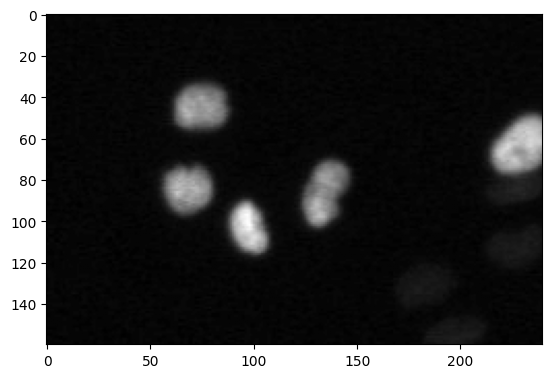

In [856]:
plt.imshow(image.squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
plt.show()

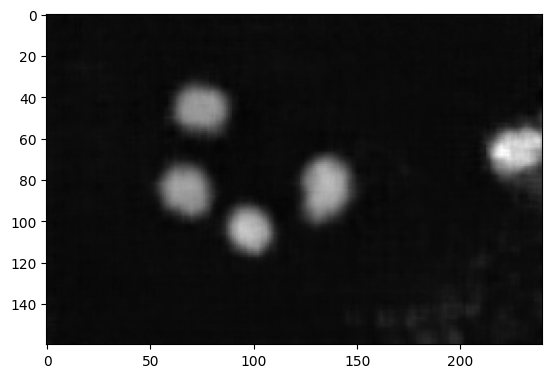

In [857]:
plt.imshow(recon_combined.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

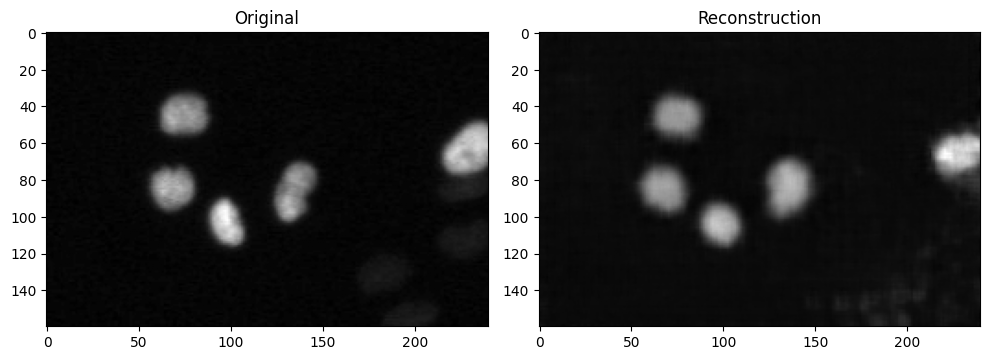

In [858]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D for easy indexing

axes[0].imshow(image.squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')           # replace with your actual data
axes[0].set_title(f"Original")

axes[1].imshow(recon_combined.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')           # replace with your actual data
axes[1].set_title(f"Reconstruction")

plt.tight_layout()
plt.show()

In [145]:
# # Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)

In [859]:
masks.shape

torch.Size([1, 25, 160, 240, 1])

In [860]:
masks = masks.squeeze(0).permute(0, 3, 1, 2).cpu().numpy()
masks.shape

(25, 1, 160, 240)

In [861]:
recons.shape

torch.Size([1, 25, 160, 240, 1])

In [862]:
recons = recons.squeeze(0).permute(0, 3, 1, 2)
recons = recons.cpu().detach().numpy()

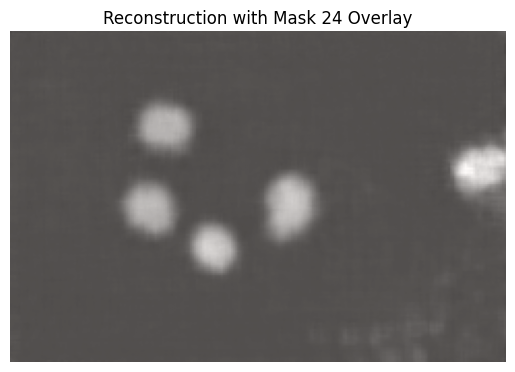

In [863]:
# Assuming recon_combined is a tensor of shape [1, C, H, W]
# and masks is a tensor of shape [N, 1, H, W]
# Mask 24 corresponds to index 23 (0-based indexing)
mask_index = 4

# Prepare the reconstruction image
recon_img = recon_combined.squeeze(0).permute(1, 2, 0).cpu().numpy()
recon_img = recon_img / recon_img.max()  # Normalize if not already

# Prepare the mask image
mask = masks[mask_index].squeeze(0)

# Create a colored overlay: Red mask with transparency
overlay = np.zeros_like(recon_img)
overlay[..., 0] = mask  # Red channel

# Display overlayed image
plt.imshow(recon_img, cmap='gray')
plt.imshow(overlay, cmap='Reds', alpha=0.3)  # alpha controls transparency
plt.title("Reconstruction with Mask 24 Overlay")
plt.axis('off')
plt.show()

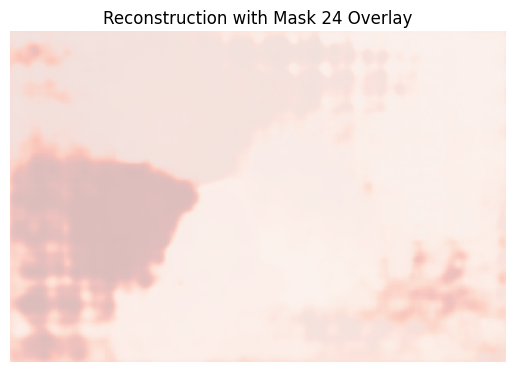

In [880]:
mask_ids = [3, 4, 5, 7, 8, 10, 11, 12, 15, 17, 18, 21, 23, 24]
mask_indices = [i - 1 for i in mask_ids]

recon_img = recon_combined.squeeze(0).permute(1, 2, 0).cpu().numpy()
recon_img = recon_img / recon_img.max()  # Normalize if not already

cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys', 'YlGn', 'YlOrBr', 'YlOrRd', 'BuPu', 'BuGn', 'GnBu', 'OrRd', 'PuBu']
overlays = []
for i, idx in enumerate(mask_indices):
    mask = masks[idx].squeeze(0)

    overlay = np.zeros_like(recon_img)
    overlay[..., 0] = mask

    overlays.append(overlay)

plt.imshow(recon_img, cmap='gray', alpha=0.5)
for i in range(len(overlays)):
    plt.imshow(overlays[i], cmap='Reds', alpha=0.3)
    
plt.title("Reconstruction with Mask 24 Overlay")
plt.axis('off')
plt.show()

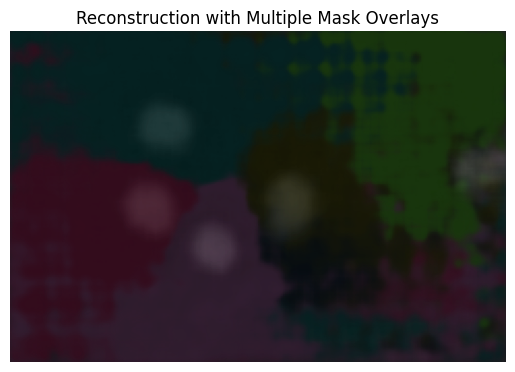

In [876]:
# Mask IDs to overlay (1-indexed in your naming, so subtract 1 for indexing)
# mask_ids = [3, 4, 5, 7, 8, 10, 11, 12, 15, 17, 18, 21, 23, 24]
mask_ids = [1, 8, 2, 7,  9, 11, 23, 6, 25, 8]
mask_indices = [i - 1 for i in mask_ids]

# Prepare the reconstruction image
recon_img = recon_combined.squeeze(0).permute(1, 2, 0).cpu().numpy()
recon_img = recon_img / recon_img.max()  # Normalize if needed

# # Convert grayscale to 3-channel if needed
if recon_img.shape[-1] == 1:
    recon_img = np.repeat(recon_img, 3, axis=2)

# Create a figure
plt.imshow(recon_img, cmap='gray', alpha=0.9)

# Colormap for distinct colors (use tab10 for up to 10 distinct colors)
# colors = cm.get_cmap('tab20', len(mask_indices))
# colors = cm.get_cmap('hsv')  # continuous hue cycle
# color_list = [colors(i / len(mask_indices))[:3] for i in range(len(mask_indices))]

# Bright distinct colors (RGB in [0,1])
additional_colors = [
    (1.0, 0.0, 1.0),   # Magenta
    (0.0, 1.0, 1.0),   # Cyan
    (1.0, 0.75, 0.8),  # Pink
    (0.5, 1.0, 0.2),   # Lime green
    (1.0, 0.85, 0.0),  # Gold
    (0.4, 0.0, 0.8),   # Indigo
    (0.0, 0.9, 0.6),   # Turquoise
    (0.9, 0.4, 0.1),   # Vermilion
]
color_list = [
    (1.0, 0.0, 0.0),  # Red
    (0.0, 1.0, 0.0),  # Green
    (0.0, 0.5, 1.0),  # Sky blue
    (1.0, 0.5, 0.0),  # Orange
    (0.7, 0.0, 1.0),  # Purple
    (1.0, 1.0, 0.0),  # Yellow
] + additional_colors


# Overlay each mask
for i, idx in enumerate(mask_indices):
    mask = masks[idx].squeeze(0)
    
    # Normalize mask if not already in [0, 1]
    mask = mask / mask.max() if mask.max() > 0 else mask
    
    # Use color i from colormap
    # color = colors(i)[:3]  # RGB tuple
    color = color_list[i]
    overlay = np.zeros_like(recon_img)
    for c in range(3):
        overlay[..., c] = color[c] * mask
    # overlay[..., 0] = color * mask

    plt.imshow(overlay, alpha=0.15)

plt.title("Reconstruction with Multiple Mask Overlays")
plt.axis('off')
plt.show()

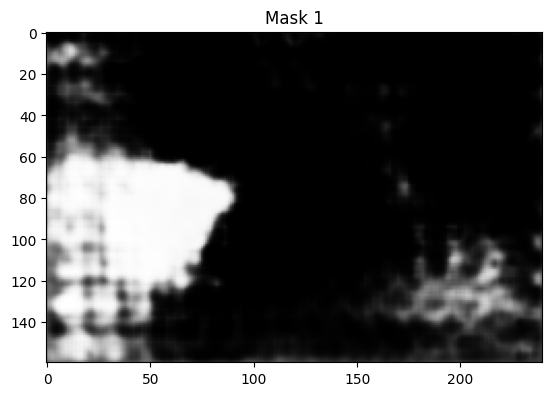

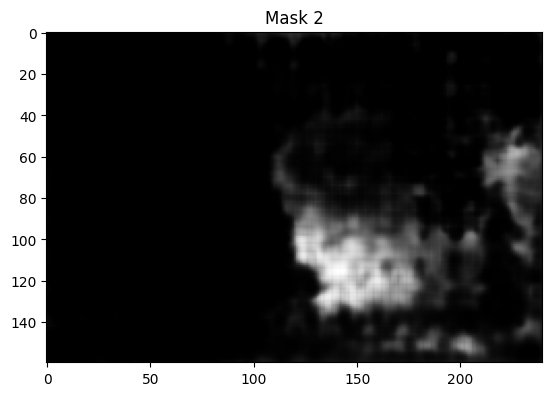

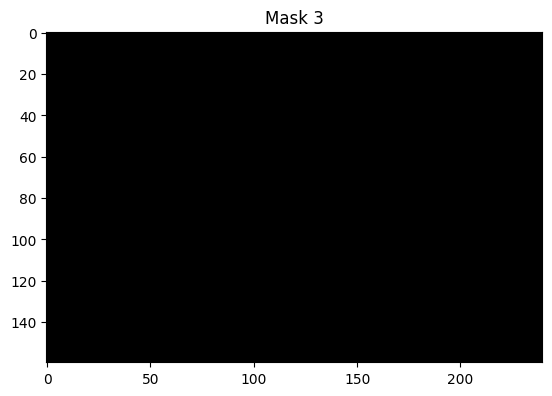

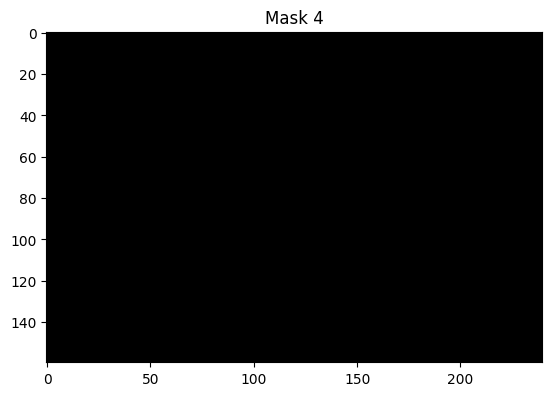

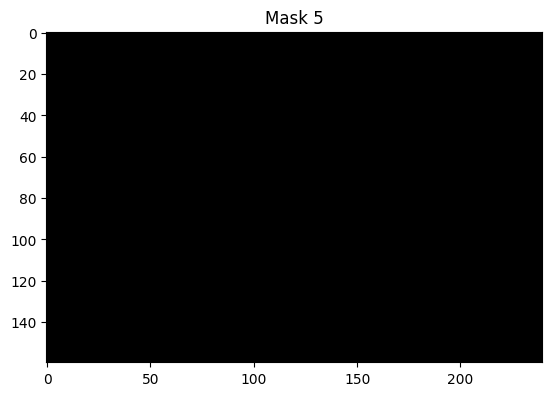

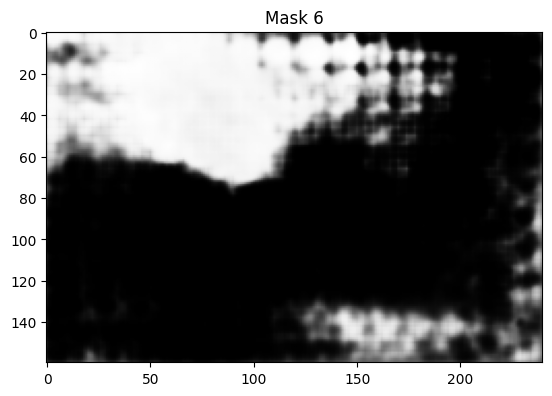

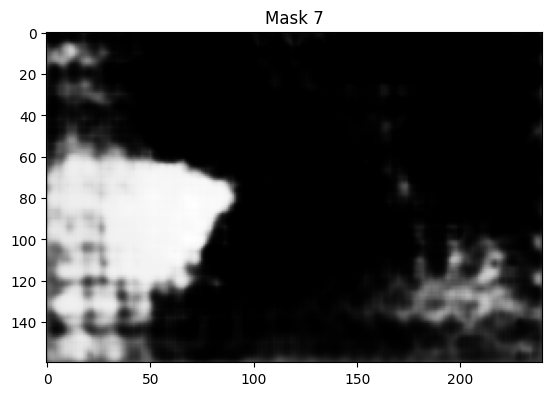

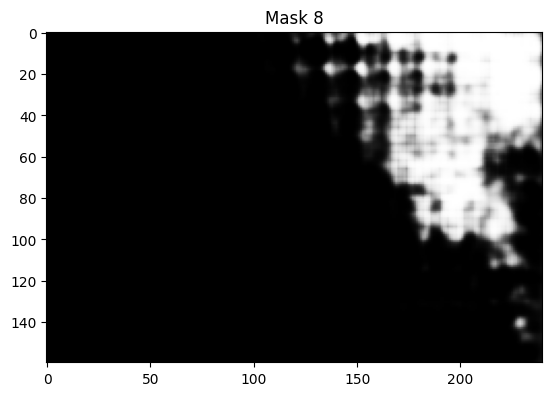

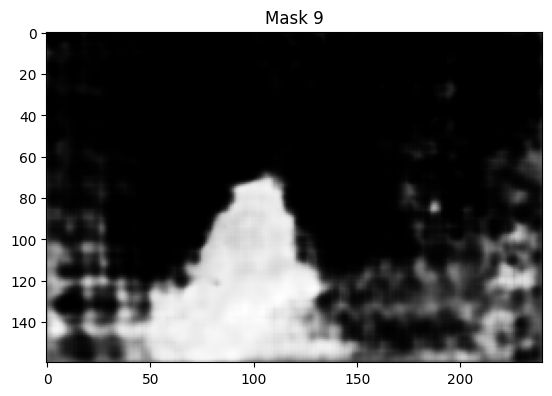

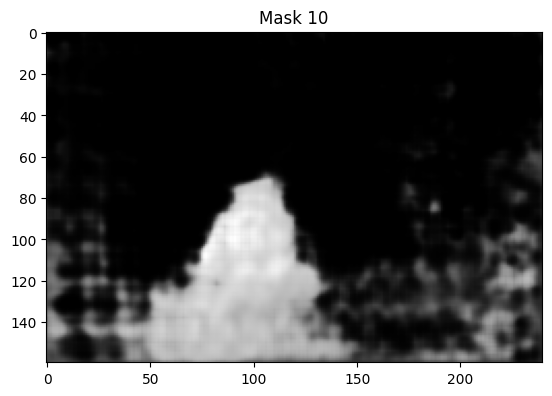

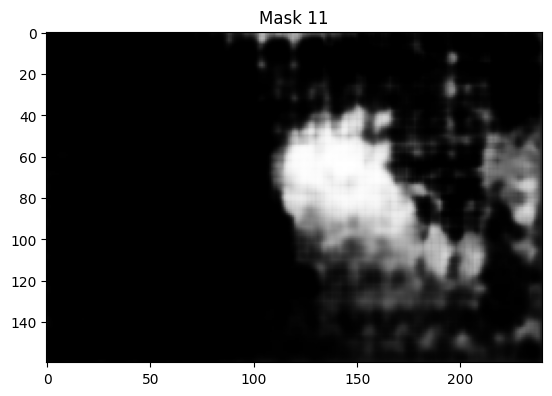

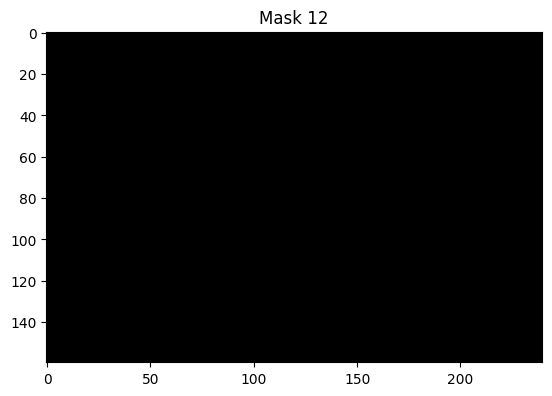

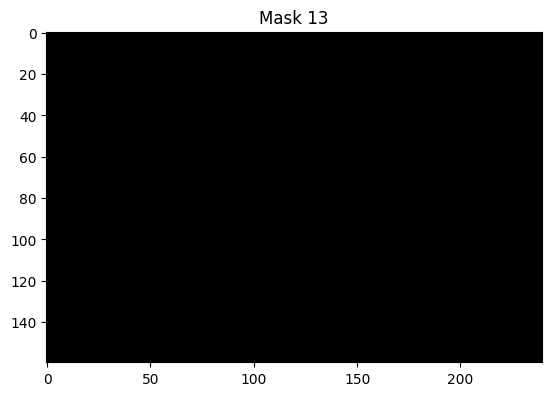

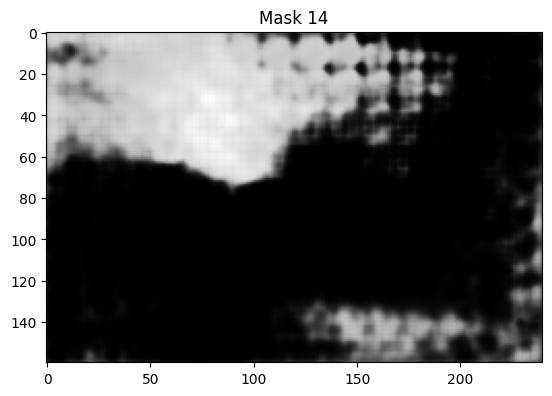

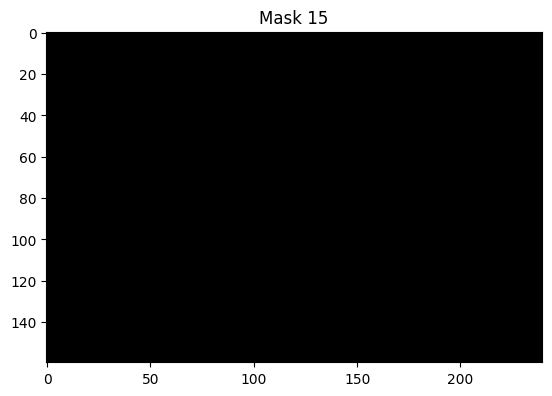

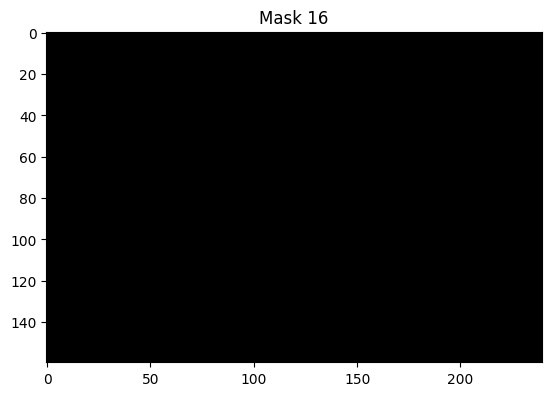

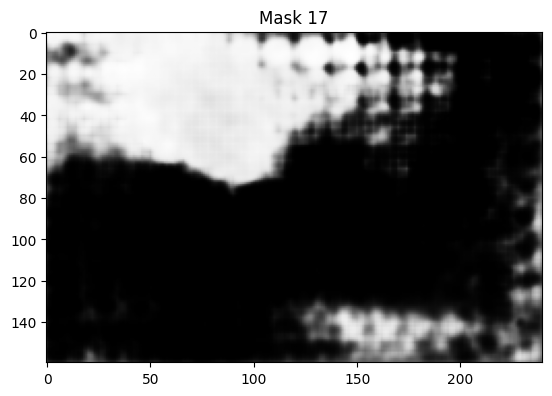

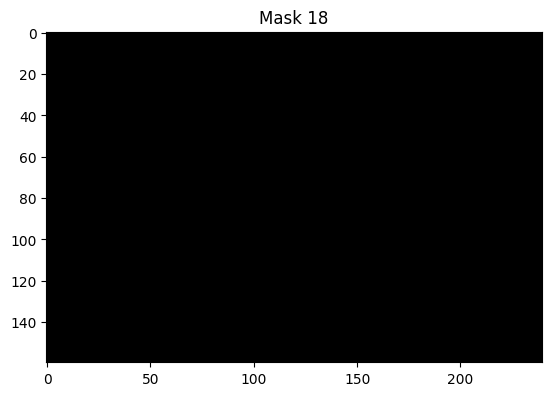

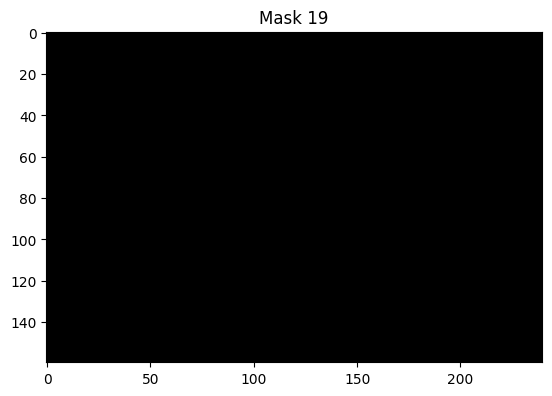

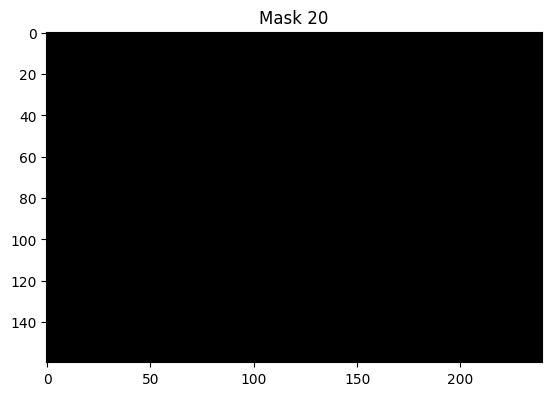

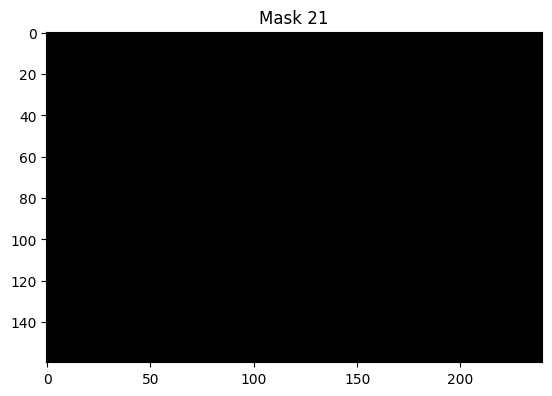

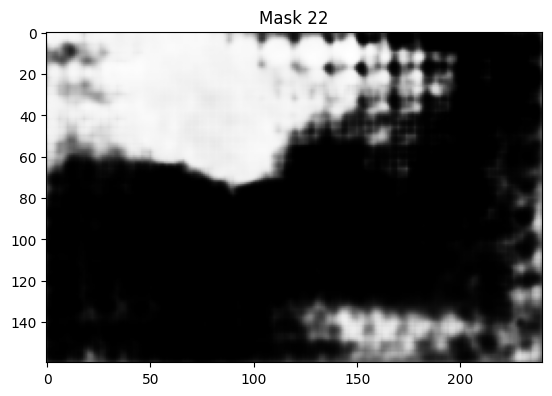

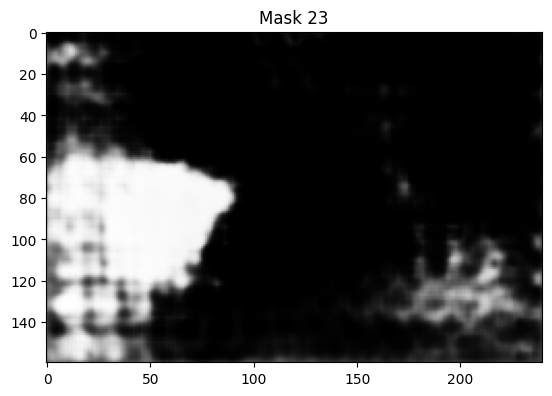

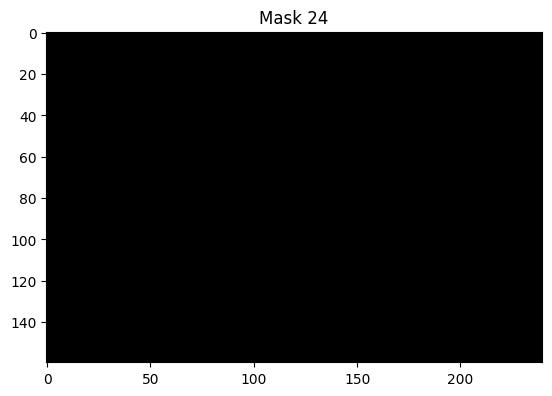

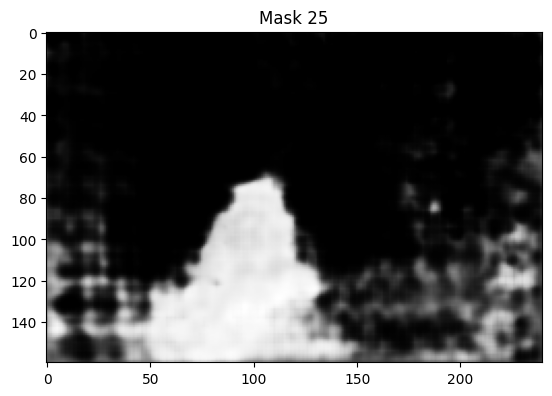

In [866]:
for i in range(masks.shape[0]):
    plt.imshow(masks[i].squeeze(0), cmap='gray')
    plt.title('Mask %s' % str(i + 1))
    plt.show()

In [78]:
masks[29]

array([[[0.0198402 , 0.01442664, 0.0127488 , ..., 0.00990733,
         0.01238463, 0.01791982],
        [0.01329166, 0.0076495 , 0.00599541, ..., 0.0038678 ,
         0.00597538, 0.01215642],
        [0.01122604, 0.00552836, 0.00425974, ..., 0.00234081,
         0.00430434, 0.01025042],
        ...,
        [0.01108256, 0.00578559, 0.00458573, ..., 0.0033311 ,
         0.00559573, 0.01206999],
        [0.01281418, 0.00746045, 0.00630491, ..., 0.0051623 ,
         0.00768983, 0.01438516],
        [0.01761189, 0.01304903, 0.01195364, ..., 0.010766  ,
         0.01376943, 0.01954895]]], shape=(1, 160, 240), dtype=float32)

In [80]:
np.exp(-10000000)

np.float64(0.0)

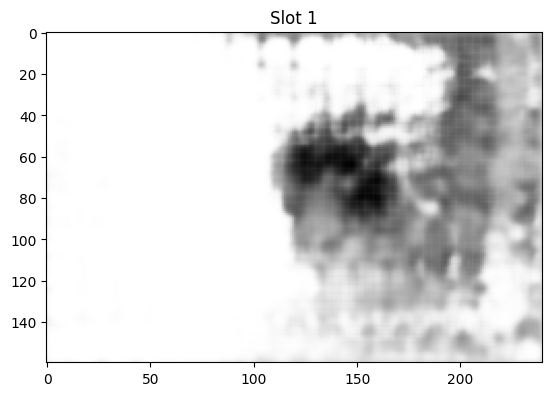

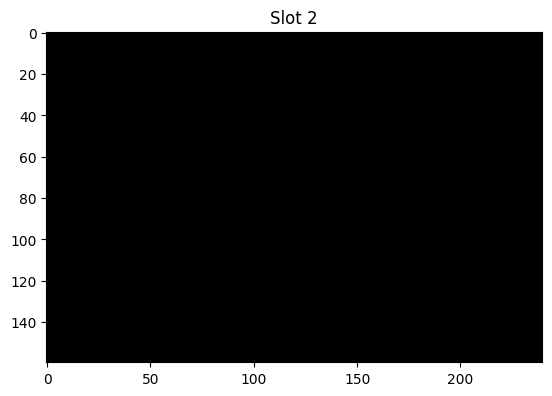

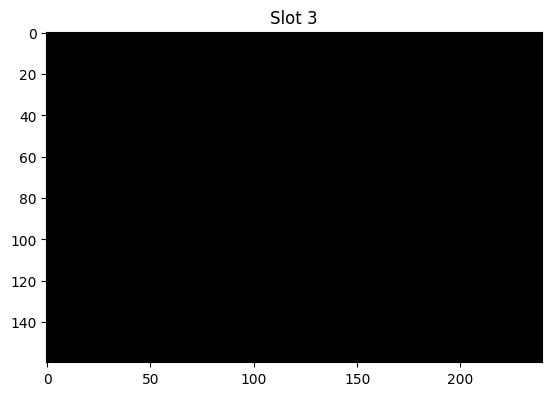

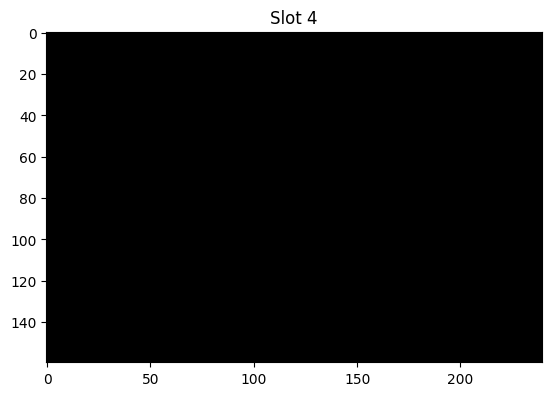

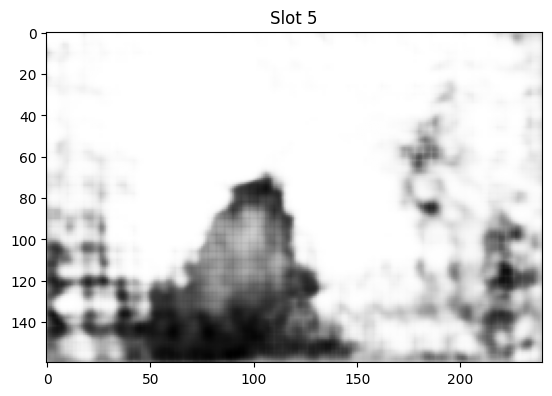

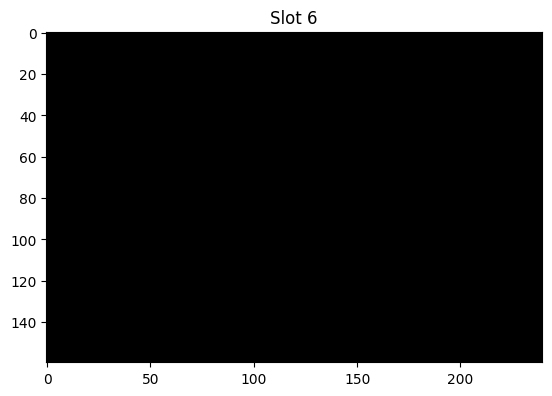

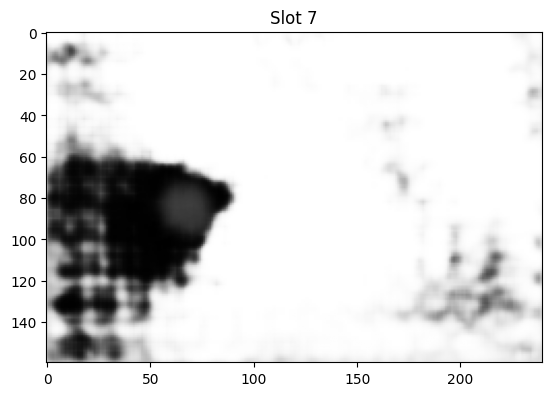

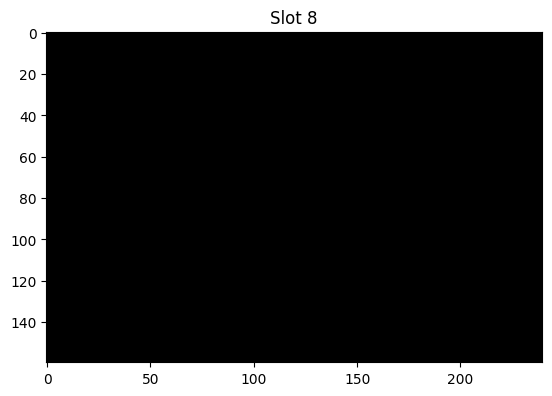

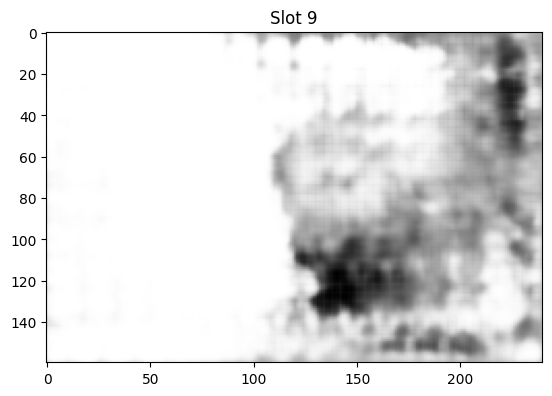

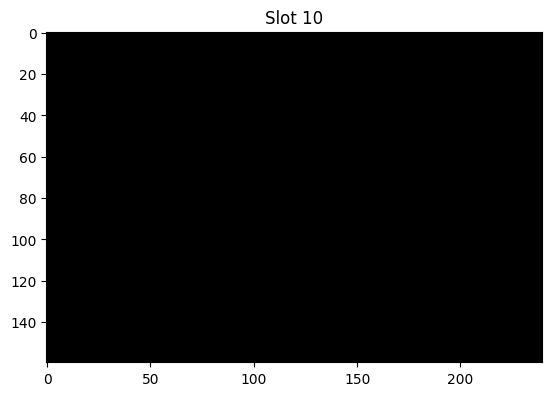

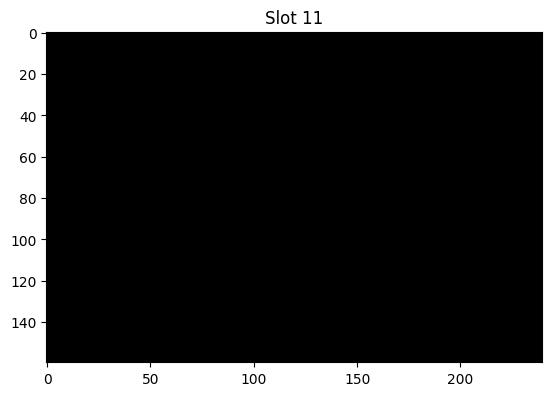

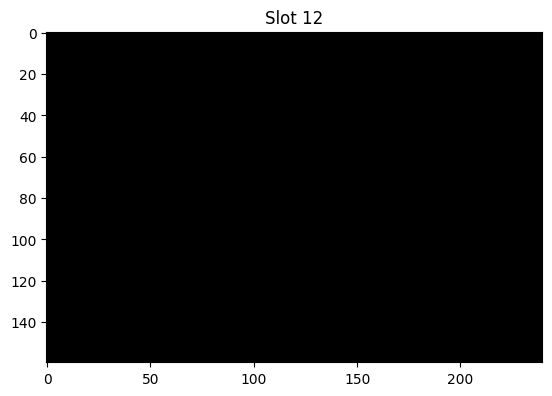

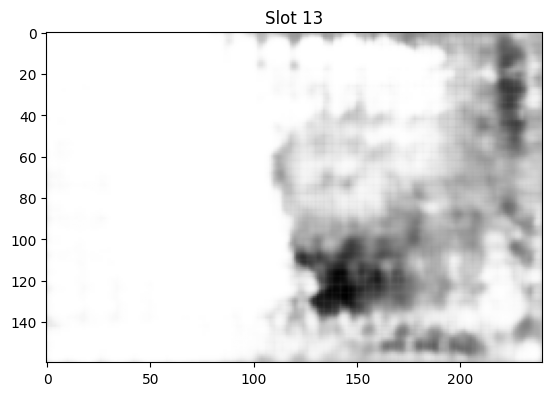

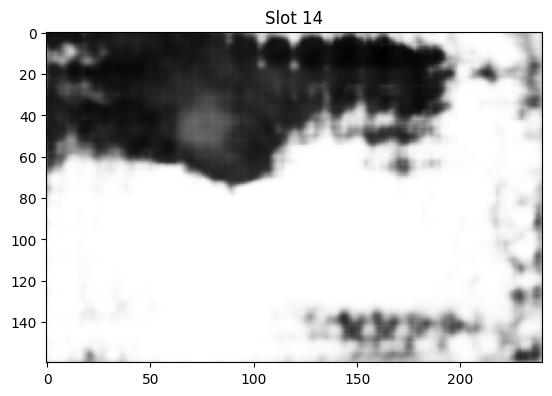

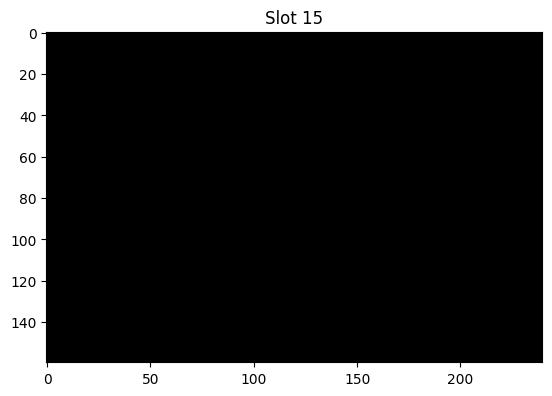

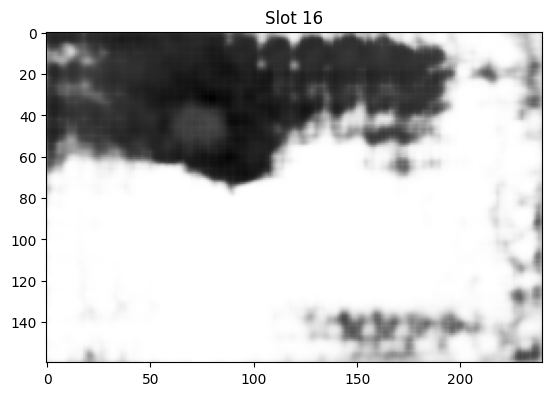

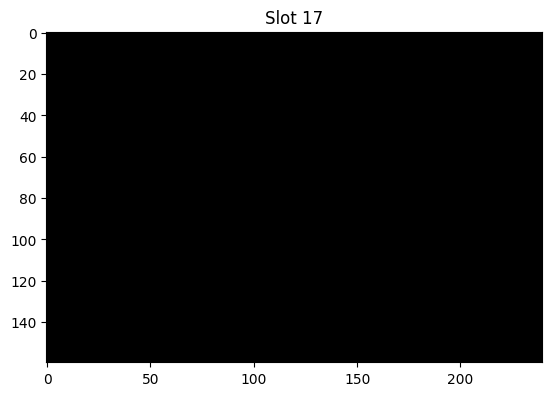

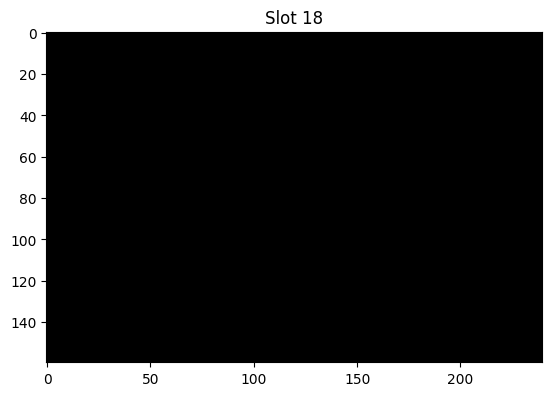

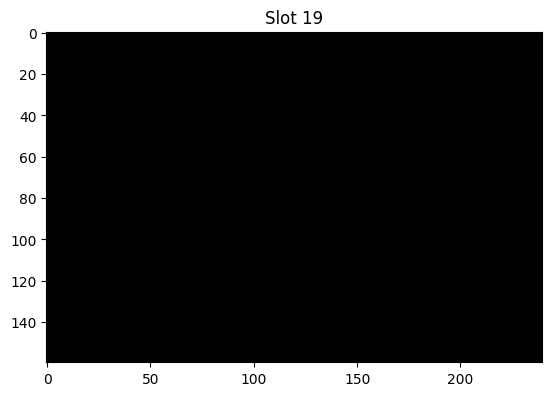

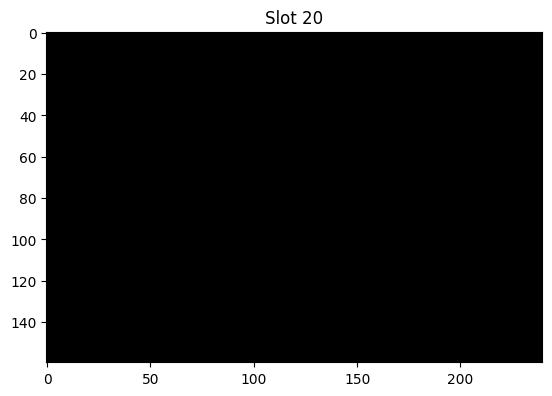

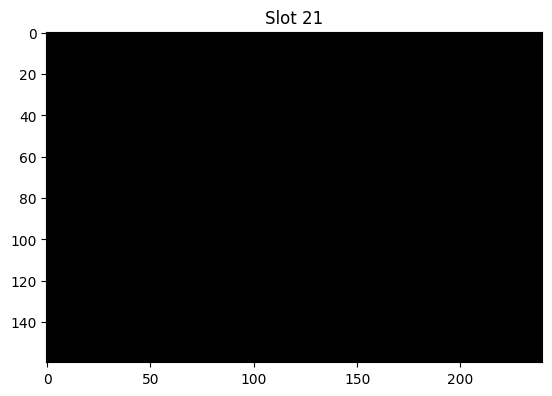

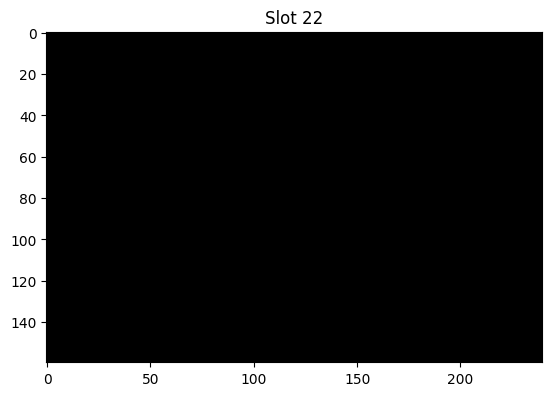

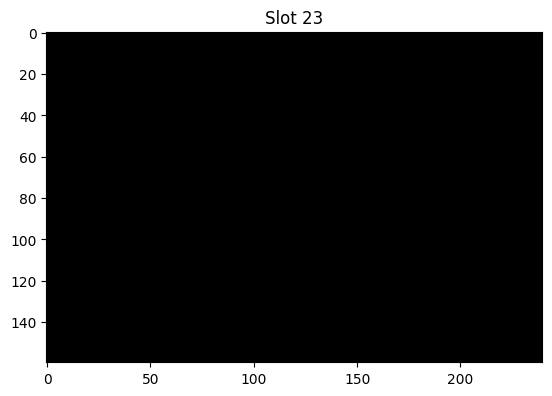

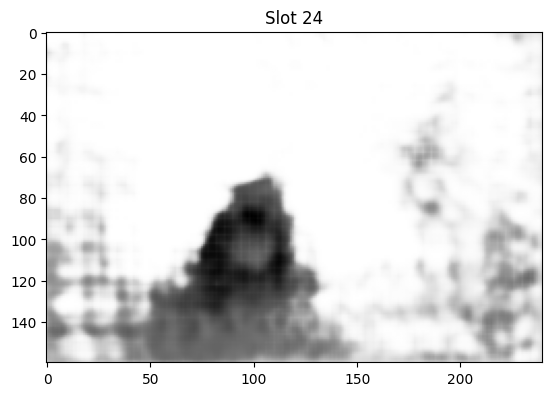

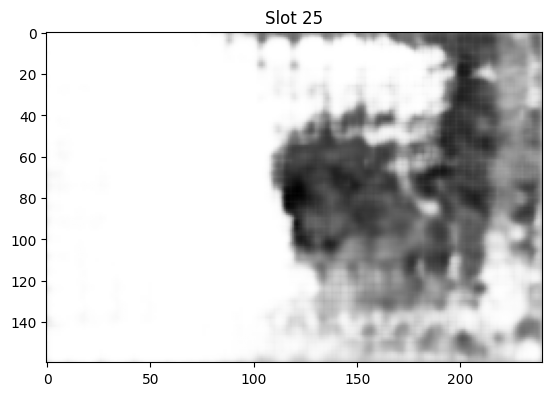

In [ ]:
for i in range(masks.shape[0]):
    picture = recons[i] * masks[i] + (1 - masks[i])
    plt.imshow(picture[0], cmap='gray')
    plt.title('Slot %s' % str(i + 1))
    plt.show()

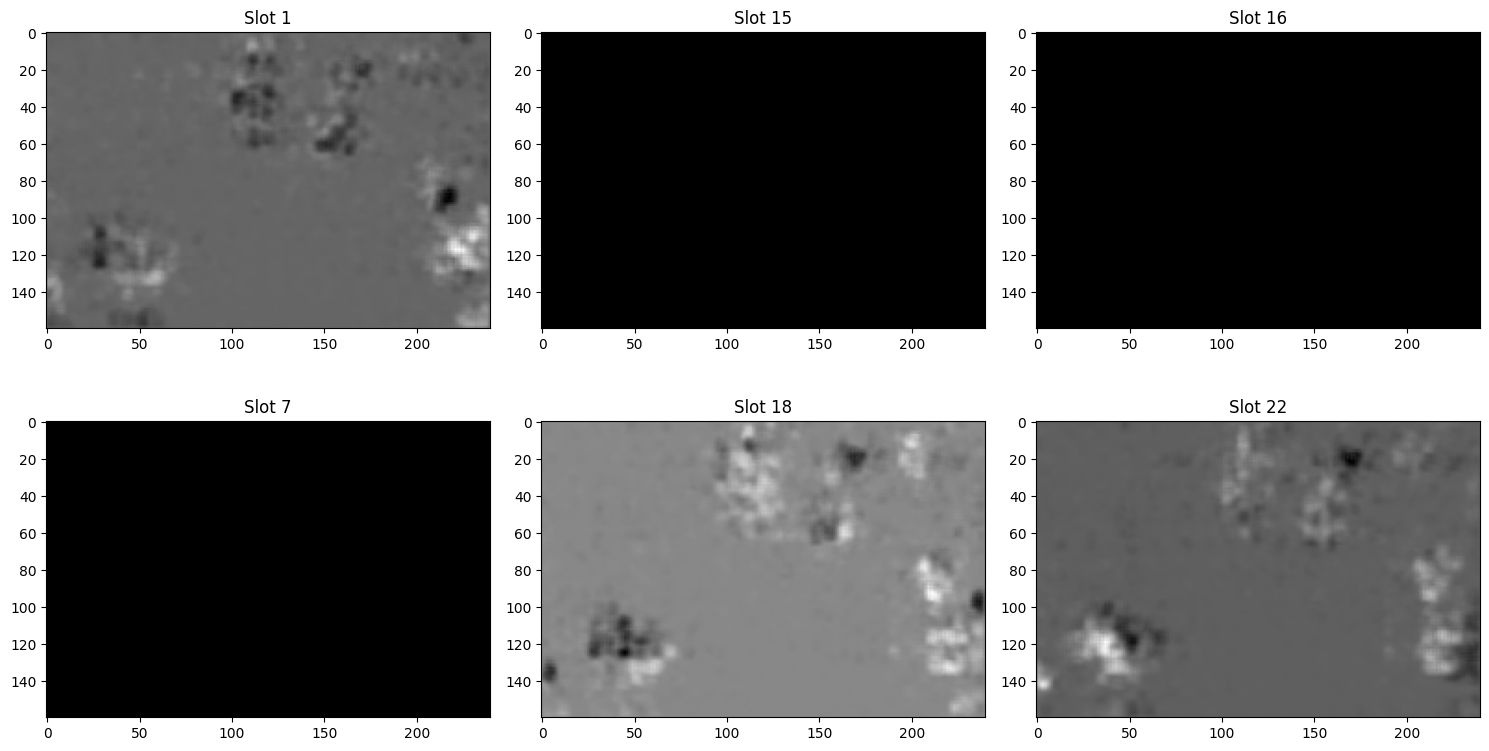

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i in range(len(to_plot)):
    axes[i].imshow(masks[to_plot[i]].squeeze(0), cmap='gray')           # replace with your actual data
    axes[i].set_title(f"Slot {to_plot[i]+1}")

plt.tight_layout()
plt.show()